SIN-393 - Introdução à Visão Computacional (2022-2)

# Teste da CNN AlexNet



---

 Montando o Google Drive

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


Importando as bibliotecas


In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils
# importando a AlexNet
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Configurações para reprodutibilidade


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Verificando o acesso à GPU


In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Dataset/pastas/pastas2/'

Definimos alguns hiperparâmetros


In [ ]:
# Número de classes
num_classes = 3

# Nomes das classes
class_names = ['Healthy', 'Diabrotica speciosa', 'Caterpillar']

# Tamanho do lote (mini-batch)
batch_size = 64 #64

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 50 # Usar durante o desenvolvimento
### epochs = 5

## Preparando o conjunto de dados
---

In [ ]:
# Treinamento
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

Spliting the dataset in training and test sets




In [ ]:
# Tamanho do dataset completo
full_size = len(full_dataset)

# Tamanhos dos conjuntos
train_size = int(0.6 * full_size)
test_size = int(0.2 * full_size)
val_size = full_size - train_size - test_size

# Divisão dos datasets
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size, val_size])

# DEBUG
print('Treino:', len(train_dataset))
print('Teste:', len(test_dataset))
print('Validação:', len(val_dataset))

# Definindo os dataloaders
#batch_size = 32  # ou qualquer outro valor que você escolher
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)


Treino: 3852
Teste: 1284
Validação: 1284


Using a pretrainned model (fine-tunning)



In [ ]:
### model_ft = models.alexnet(pretrained=True)
model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Altera o número de neurônios na cadama de saída.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

## Selecionando o modelo
---

In [ ]:
# Simple net
### model = Net(3, 5)

# Pretrainned
model = model_ft

In [ ]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Loss function and optimizer

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

## Training the model
---

In [ ]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        # 'outputs' está em porcentagens. Tomar os maximos como resposta.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(num_hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval()

    # Pego o numero de perda e o numero de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Numero de itens corretos

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs)

        # Retorna a maior predicao.
        #### _, preds = torch.max(outputs, 1)
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # # Atualiza os acertos da época
        num_hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    ### scheduler.step()

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(num_hits_epoch_val.double() / val_size)

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

Epoch 0/49 - TRAIN Loss: 0.6299 TRAIN Acc: 0.7422 - VAL. Loss: 0.5373 VAL. Acc: 0.7702 (1456.1873 seconds)
Epoch 1/49 - TRAIN Loss: 0.4602 TRAIN Acc: 0.8240 - VAL. Loss: 0.4079 VAL. Acc: 0.8629 (47.1211 seconds)
Epoch 2/49 - TRAIN Loss: 0.3684 TRAIN Acc: 0.8650 - VAL. Loss: 0.3820 VAL. Acc: 0.8551 (46.6524 seconds)
Epoch 3/49 - TRAIN Loss: 0.3074 TRAIN Acc: 0.8946 - VAL. Loss: 0.3720 VAL. Acc: 0.8505 (46.3109 seconds)
Epoch 4/49 - TRAIN Loss: 0.2570 TRAIN Acc: 0.9102 - VAL. Loss: 0.3610 VAL. Acc: 0.8762 (46.7071 seconds)
Epoch 5/49 - TRAIN Loss: 0.2081 TRAIN Acc: 0.9320 - VAL. Loss: 0.3299 VAL. Acc: 0.8769 (46.9945 seconds)
Epoch 6/49 - TRAIN Loss: 0.1925 TRAIN Acc: 0.9338 - VAL. Loss: 0.3444 VAL. Acc: 0.8731 (46.5470 seconds)
Epoch 7/49 - TRAIN Loss: 0.1524 TRAIN Acc: 0.9470 - VAL. Loss: 0.3990 VAL. Acc: 0.8590 (46.5478 seconds)
Epoch 8/49 - TRAIN Loss: 0.1427 TRAIN Acc: 0.9499 - VAL. Loss: 0.3965 VAL. Acc: 0.8808 (46.8717 seconds)
Epoch 9/49 - TRAIN Loss: 0.1351 TRAIN Acc: 0.9551 - V

Analisando o treinamento


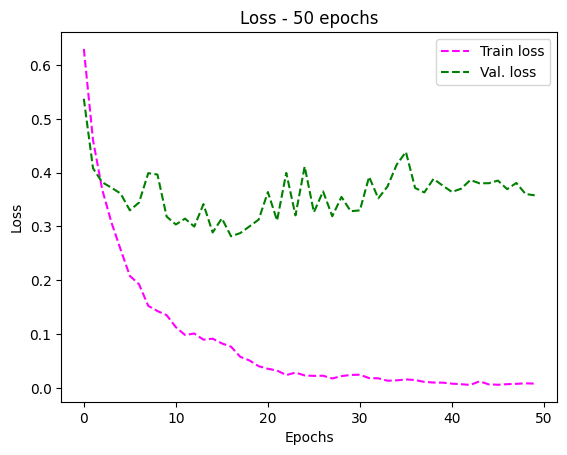

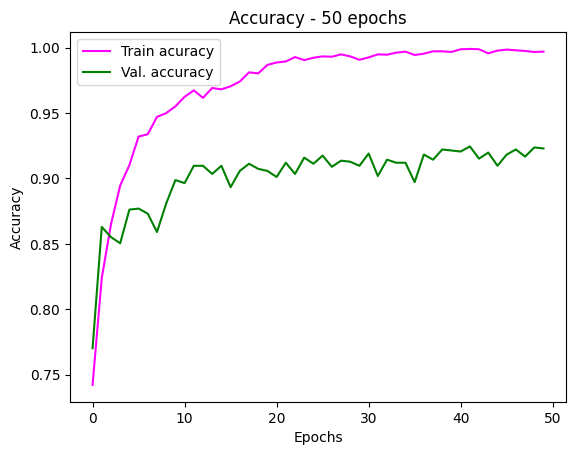

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Titulo - Loss and accuracy chart
loss_title = 'Loss - ' + str(epochs) + ' epochs'
acc_title = 'Accuracy - ' + str(epochs) + ' epochs'

# Plot - Loss
plt.figure()
plt.title(loss_title)
plt.plot(epochs_list, train_loss_list, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green' ,ls='--', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.savefig('alexnet_loss.pdf')

# Plot - Accuracy
plt.figure()
plt.title(acc_title)
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('alexnet_acc.pdf')

Evaluating the model


In [ ]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(val_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = labelList.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_val_batch = np.asarray(labelList.cpu())
        pred_val_batch = np.asarray(preds.cpu())

    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

Confusion matrix and classification report


In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[622  22  17]
 [ 34 415   9]
 [ 13   4 148]]

Class. report (validation)
                     precision    recall  f1-score   support

            Healthy     0.9297    0.9410    0.9353       661
Diabrotica speciosa     0.9410    0.9061    0.9232       458
        Caterpillar     0.8506    0.8970    0.8732       165

           accuracy                         0.9229      1284
          macro avg     0.9071    0.9147    0.9106      1284
       weighted avg     0.9236    0.9229    0.9230      1284



Validation Acc.: 0.9229
